# Imports

In [1]:
import pandas as pd
import requests
import dateutil.parser
import datetime 
from datetime import datetime as dt
from datetime import timedelta
import numpy as np
import time
import string
import missingno as msno
from scipy import stats
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
sns.set_style('white')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 300

# Question 1

In [2]:
def get_data(ticker,currency,to_date):
    
    """
    Return 30d data. Limit in url is set to "30" revise for more historical data
        
        args
        ticker: str 
        currency: str exp(USD,GBP..etc) 
        to_date: str formated 06/19/2022
    """
    
    # Create the url
    url = f"https://min-api.cryptocompare.com/data/histoday?fsym={ticker}&tsym={currency}&limit=30&toTs={to_date}"
    # Get the json
    r = requests.get(url)
    # Get the data
    data = r.json()

    return data

ticker = "BTC"
currency = "USD"
to_date = "06/19/2022"

to = dateutil.parser.parse(to_date, dayfirst=False).timestamp()

data_raw = get_data(ticker,currency,to)

In [3]:
# create dataframe
df = pd.DataFrame(data_raw['Data'])

#convert time format, pull close price and generate new dateframe
dts = pd.to_datetime(df['time'],unit="s") 
cl  = df['close']
btc_df = pd.DataFrame({'time': dts.values, ticker: cl.values})
btc_df = pd.DataFrame(cl.values, index=dts.values,columns=[ticker])
btc_df.index.name = 'Time'

In [4]:
btc_df.head()

,BTC
Time,
2022-05-20,29166.15
2022-05-21,29410.72
2022-05-22,30264.29
2022-05-23,29075.68
2022-05-24,29630.05


In [5]:

def get_gbtc_data(time_frame, ticker):
    
    """ 
        Return gbtc ticker data from canvas component on website 
        
        args
        ticker: str
        time_frame: str (examples 1D,1M,6M)
    """
    
    # Create the url
    url2 = f'https://ts-api.cnbc.com/harmony/app/charts/{time_frame}.json?symbol={ticker}'
    # Get the json
    r = requests.get(url2)
    # Get the data
    data = r.json()

    return data

time_frame = '1M'
ticker = 'gbtc'

data_raw = get_gbtc_data(time_frame, ticker)


In [6]:
# get data from json into dataframe
company_name = data_raw['barData']['companyName']

gbtc = data_raw['barData']['priceBars']

df = pd.DataFrame.from_records(gbtc)

In [7]:
dts = pd.to_datetime(df['tradeTime']) 
cl  = df['close']
gbtc_df = pd.DataFrame({'time': dts.values, ticker: cl.values})
gbtc_df = pd.DataFrame(cl.values, index=dts.values,columns=[ticker])
gbtc_df.index.name = 'Time'
gbtc_df['gbtc'] = gbtc_df['gbtc'].astype(float)

In [8]:
gbtc_df.head()

,gbtc
Time,
2021-06-21,27.70
2021-06-22,28.01
2021-06-23,27.79
2021-06-24,29.61
2021-06-25,27.68


In [9]:
# merge dfs
data_frames = [btc_df,gbtc_df]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Time'],how='left'), 
                   data_frames).replace(to_replace=np.nan, method='bfill')

#not end of day yet for GBTC, so had to forward fill price from fridays' close 
#(not 24hr market)
df_merged['gbtc'] = df_merged['gbtc'].ffill()

In [10]:
# check bb/ff worked correctly
df_merged.head(30)

,BTC,gbtc
Time,,
2022-05-20,29166.15,18.7400
2022-05-21,29410.72,18.4400
2022-05-22,30264.29,18.4400
2022-05-23,29075.68,18.4400
2022-05-24,29630.05,18.6200
2022-05-25,29508.27,19.0700
2022-05-26,29188.71,19.0400
2022-05-27,28597.33,18.9600
2022-05-28,29013.53,20.5400


In [11]:
# 692.37m shares outstanding as of 1Q22
shares_out = 692370000.00

btc_gbtc_ratio = 0.00092683

qty_btc_held = btc_gbtc_ratio * shares_out

In [13]:
#create cols to get premium/discount 
df_merged['shares_out'] = shares_out
df_merged['btc_held'] = qty_btc_held
df_merged['gbtc_mkt_cap'] = df_merged['shares_out'] * df_merged['gbtc']
df_merged['nav'] = df_merged['BTC'] * df_merged['btc_held']
df_merged['prem_disc'] = df_merged['gbtc_mkt_cap'] / df_merged['nav'] - 1.0 

#send to csv 
df_merged.to_csv("./data/btc_gbtc_data.csv")

In [14]:
df_merged.head()

,BTC,gbtc,shares_out,btc_held,gbtc_mkt_cap,nav,prem_disc
Time,,,,,,,
2022-05-20,29166.15,18.74,692370000.0,641709.2871,1.297501e+10,1.871619e+10,-0.306749
2022-05-21,29410.72,18.44,692370000.0,641709.2871,1.276730e+10,1.887313e+10,-0.323520
2022-05-22,30264.29,18.44,692370000.0,641709.2871,1.276730e+10,1.942088e+10,-0.342599
2022-05-23,29075.68,18.44,692370000.0,641709.2871,1.276730e+10,1.865813e+10,-0.315725
2022-05-24,29630.05,18.62,692370000.0,641709.2871,1.289193e+10,1.901388e+10,-0.321973


# Viz for BTC & GBTC 

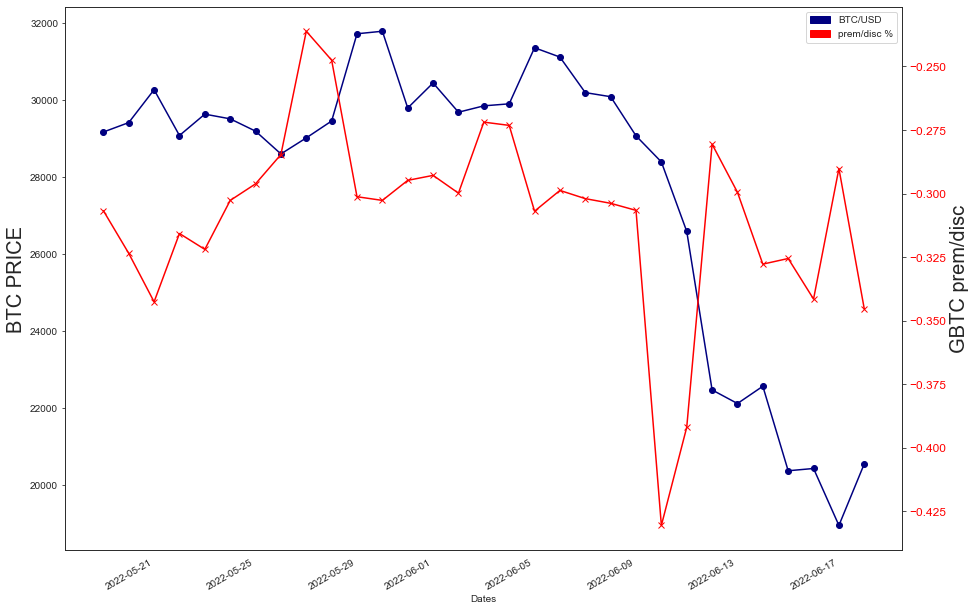

In [16]:
# generate a plot to viz prem/disc vs btc price

#Establish figure size, ax
fig,ax1 = plt.subplots(figsize = (15, 10))

ax1.set_xlabel('Dates')
plt.ylabel("BTC PRICE",fontsize=20)
ax1.plot(df_merged.index, df_merged['BTC'], color = 'navy',marker='o')
ax1.tick_params(axis='y')
l1 = mpatches.Patch(color='navy', label='BTC/USD')
# Rotate text
plt.xticks(rotation = 30)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('prem/disc')  # we already handled the x-label with ax1
ax2.plot(df_merged.index, df_merged['prem_disc'],color='red', marker='x')
ax2.tick_params(axis='y', labelcolor='red')
l2 = mpatches.Patch(color='red', label='prem/disc %')
plt.ylabel('GBTC prem/disc',fontsize=20)
# Enlarge tick marks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(handles=[l1,l2]);

In [1]:
# generate Benchmark % chg
df_pct1H['Benchmark_%'] = ((df_pct1H['ETH'] * (1/10)) + (df_pct1H['XLM'] * (1/10)) + \
                           (df_pct1H['LTC'] * (1/10)) + (df_pct1H['ETC'] * (1/10)) + \
                           
                           
                           
#rename cols
dfcol1 = 'ETH'
                           
# create 2 dfs based on survival
df_madeit = df[df['survived'] == 1]
df_didnt = df[df['survived'] == 0]
                           
                           
                           
#What is the survival rate for children (under 12) in each Pclass? Answer: 

children_under12 = df_madeit[df_madeit['age'] < 12].sort_values(by=['pclass'])

children_under12.pclass.value_counts()

plt.figure(figsize = (12,7))
plt.bar(children_under12['pclass'],children_under12['age'],color='navy')
plt.xticks(rotation = 3)

# title,x and y labels
plt.title('children under 12 that survived by p_class ')
plt.xlabel('pclass')
plt.ylabel('frequency');
                           
                           
                           


SyntaxError: unexpected EOF while parsing (<ipython-input-1-1945f723e0a0>, line 3)

# Question 2